# Прогнозирование оттока пользователей.

В этом соревновании предстоит спрогнозировать клиентов телеком оператора, склонных к оттоку.

Необходимо построить модель, прогнозирующую клиентов, склонных к оттоку. В качестве результата, требуется не просто выбрать к какому классу ('1' - отток, '-1' - не отток) относится пользователь, но и дать вероятностную оценку, т.е. оценить с какой вероятностью клиент относится к классу отток.

# Описание полей.

Данные являются закрытыми и предоставляются без описания. Датасет состоит из 230 признаков, из которых первые 190 - числовые, и оставшиеся 40 - категориальные.

# Оценка качества

Оценка качества проводится с помощью метрики ROC-AUC (receiver operating characteristic - area under curve, или площадь под ROC-кривой).
Площадь под кривой будет характеризовать  качество оценок принадлежности к первому классу (класс `отток`).

Так же стоит понимать, что ROC-AUC имеет смысл вероятности того, что если были выбраны случайный положительный (класс `отток`) и отрицательный объекты выборки, то положительный объект получит оценку принадлежности выше, чем отрицательный объект.

In [1]:
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
sns.set(style="ticks")

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay

# for the Q-Q plots
# import scipy.stats as stats

## Загрузка и обзор данных

In [2]:
df = pd.read_csv('orange_small_churn_train_data.csv')

In [3]:
df.head()

,ID,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,labels
0,0,NaN,NaN,NaN,NaN,NaN,3052.0,NaN,NaN,NaN,...,vr93T2a,LM8l689qOp,NaN,NaN,fKCe,02N6s8f,xwM2aC7IdeMC0,NaN,NaN,-1.0
1,1,NaN,NaN,NaN,NaN,NaN,1813.0,7.0,NaN,NaN,...,6hQ9lNX,LM8l689qOp,NaN,ELof,xb3V,RAYp,55YFVY9,mj86,NaN,-1.0
2,2,NaN,NaN,NaN,NaN,NaN,1953.0,7.0,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,NaN,FSa2,ZI9m,ib5G6X1eUxUn6,mj86,NaN,-1.0
3,3,NaN,NaN,NaN,NaN,NaN,1533.0,7.0,NaN,NaN,...,e4lqvY0,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN,1.0
4,4,NaN,NaN,NaN,NaN,NaN,686.0,7.0,NaN,NaN,...,MAz3HNj,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN,-1.0


Набор данных включает в себя метки классов (последний столбец). В данных имеются пропуски, значения категориальных переменных закодированы (нет понимания что означают значения категориальных признаков).

In [4]:
df.shape

(18299, 232)

In [5]:
# посмотрим на долю пропущенных значений для каждого признака
df.isnull().mean()

ID        0.000000
Var1      0.985737
Var2      0.974425
Var3      0.974479
Var4      0.969233
            ...   
Var227    0.000055
Var228    0.000055
Var229    0.566479
Var230    1.000000
labels    0.000055
Length: 232, dtype: float64

Видно, что в целевой переменной имеются пропуски. Посмотрим на количество пропусков.

In [6]:
df['labels'].isnull().sum()

1

В тренировочном наборе данных отсутствует метка класса в одном из объектов. Найдем и избавимся от этого объекта.

In [7]:
df.isnull()[df.isnull().labels == True]

,ID,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,labels
18298,False,True,True,True,True,True,False,False,True,True,...,True,True,True,True,True,True,True,True,True,True


In [8]:
objects_for_remove = list(df.isnull()[df.isnull().labels == True].index)
print(f'количество объектов, в которых отсутствует метка класса = {len(objects_for_remove)}')
objects_for_remove

количество объектов, в которых отсутствует метка класса = 1


[18298]

In [9]:
# удаление объекта, где отсутствует метка класса
df.drop(objects_for_remove, axis=0, inplace=True)

In [10]:
# Основные статистические характеристики набора данных
df.describe()

,ID,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,...,Var184,Var185,Var186,Var187,Var188,Var189,Var190,Var209,Var230,labels
count,18298.000000,261.000000,468.000000,467.000000,563.000000,5.000000e+02,16307.000000,16322.000000,0.0,261.000000,...,468.000000,0.0,261.000000,261.000000,468.000000,7681.000000,104.000000,0.0,0.0,18298.000000
mean,9148.500000,10.789272,0.010684,594.308351,0.079929,2.764255e+05,1304.059177,6.791141,NaN,51.026820,...,5.564103,NaN,3.471264,17.111111,164.132692,269.753157,20176.838654,NaN,NaN,-0.849492
std,5282.321948,35.387167,0.231125,6322.659738,0.845128,7.546352e+05,2442.495924,6.283886,NaN,163.530435,...,12.953473,NaN,8.802761,53.817704,113.378672,86.739021,29390.584919,NaN,NaN,0.527616
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,NaN,0.000000,...,0.000000,NaN,0.000000,0.000000,0.000000,6.000000,0.000000,NaN,NaN,-1.000000
25%,4574.250000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,518.000000,0.000000,NaN,6.000000,...,0.000000,NaN,0.000000,0.000000,19.380000,204.000000,2139.952500,NaN,NaN,-1.000000
50%,9148.500000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,854.000000,7.000000,NaN,22.000000,...,0.000000,NaN,0.000000,4.000000,193.980000,270.000000,9357.884500,NaN,NaN,-1.000000
75%,13722.750000,8.000000,0.000000,0.000000,0.000000,1.260125e+05,1428.000000,7.000000,NaN,46.000000,...,4.000000,NaN,6.000000,18.000000,246.135000,324.000000,26236.440000,NaN,NaN,-1.000000
max,18297.000000,392.000000,5.000000,130668.000000,9.000000,6.048550e+06,114079.000000,35.000000,NaN,2300.000000,...,132.000000,NaN,78.000000,634.000000,628.620000,642.000000,191167.200000,NaN,NaN,1.000000


Как видим, в таблице 232 столбца, в т.ч. столбцы: ID (по сути не является признаком) и label (метка класса). Итоговое количество признаков составляет 230. В признаках присутствуют пропуски.

Удалим столбец ID.

In [11]:
df.drop('ID', axis=1, inplace=True)

In [12]:
# посмотрим на уникальные значения целевого признака
df['labels'].unique()

array([-1.,  1.])

Целевой признак является бинарным и содержит значения -1 и 1.

#### Определим имена числовых и категориальных признаков

По условиям задачи известно, что первые 190 признаков - числовые, остальные 40 - категориальные.

In [13]:
num_features = set(df.columns[:190])
cat_features = set(df.columns[190:230])

print(f"кол-во числовых признаков составляет {len(num_features)}")
print(f"кол-во категориальных признаков составляет {len(cat_features)}")

кол-во числовых признаков составляет 190
кол-во категориальных признаков составляет 40


Отделим обучающую выборку и метки классов из набора данных.

In [14]:
df, labels = df.iloc[:, :-1], df.iloc[:,-1]

In [15]:
df.shape

(18298, 230)

In [16]:
labels.shape

(18298,)

Посмтрим на баланса классов

In [17]:
labels.value_counts() / len(labels)

-1.0    0.924746
 1.0    0.075254
Name: labels, dtype: float64

В нашей задаче прогнозирования клиентов склонных к оттоку имеется дисбаланс классов. Объясняется тем, что количество 'отточных' клиентов всегда меньше, чем тех, кто продолжает оставаться клиентами компании.

#### Отложенная выборка

In [18]:
df, df_test, labels, labels_test = train_test_split(df, labels, test_size=0.2, shuffle=True, random_state=1, stratify=labels)

In [19]:
df.shape

(14638, 230)

In [20]:
labels.shape

(14638,)

# Первичный отбор признаков

#### Создадим функцию, которая удаляет заданные признаки в наборе данных, а так же обновляет списки оставшихся после удаления числовых и категориальных имен признаков.

In [21]:
def del_features(df, features_for_remove, number_features=num_features, categorical_features=cat_features):
    """
    Remove features in df and update feature names of df after removing.
    """
    global num_features
    num_features = list(set(num_features) - set(features_for_remove))
    global cat_features
    cat_features = list(set(cat_features) - set(features_for_remove))
    try:
        df.drop(features_for_remove, axis=1, inplace=True)
    except KeyError:
        print('Не найдены признаки для удаления!')

#### Визуализируем пропуски

In [22]:
def null_map(data):
    #Show null map of the data
    
    data_to_heat = data.isnull()
    null_count = (data_to_heat == True).sum().sum()
    with plt.xkcd():
        plt.figure(figsize=(20,14))
        if null_count > 0:
            colors = ['#000099', '#ffff00'] 
        else:
            colors = ['#000099'] 
        sns.heatmap(data_to_heat,cmap = sns.color_palette(colors));

In [23]:
# null_map(df)

Имеются признаки, в которых очень много пропусков (в визуальном представлении представлены `желтым цветом`). В дальнейшем будет определеять признаки, в которых доля пропусков выше заданного порога, для дальнейшего исключения этих признаков из тренировочного набора данных.

### Отбор признаков по количеству известных значений

In [24]:
def get_features_high_gaps(df, critical_proportion=0.3):
    """
    Find features where proportion of missing values more than critical_proportion
    Return: list of feature names (to be removed)
    """
    to_drop = []
    for col in df.columns:
        gap_proportion = df[col].isnull().sum() / len(df[col])
        if gap_proportion > critical_proportion:
            to_drop.append(col)
    return to_drop

#### Заведем словарь, в котором в качестве значений будем хранить списки имен признаков, подлежащих удалению из тренировочного набора данных (много пропусков, константный признак и т.п.). В дальнейшем понадобится при подготовке данных в отложенной выборке.

In [25]:
features_for_remove = dict()

<span style="color:Blue;font-weight:bold">
1) Найдем и удалим признаки, в которых доля пропусков выше заданного порога.
</span>

In [26]:
# здесь использую critical_proportion=0.6, т.к. именно этот вариант дал лучшие результаты на отложенной выборке.
features_for_remove['high_gaps'] = get_features_high_gaps(df, critical_proportion=0.6)
del_features(df, features_for_remove['high_gaps'])
print('Кол-во удаленных признаков, в которых количество пропусков выше заданного порога, составляет =',
    len(features_for_remove['high_gaps'])
     )
print(f"кол-во оставшихся числовых признаков = {len(num_features)}")
print(f"кол-во оставшихся категориальных признаков = {len(cat_features)}")

Кол-во удаленных признаков, в которых количество пропусков выше заданного порога, составляет = 156
кол-во оставшихся числовых признаков = 42
кол-во оставшихся категориальных признаков = 32


Посмотрим на тепловую карту пропусков в данных, после удаления признаков, в которых имелось много пропусков.

In [27]:
# null_map(df)

### Отбор числовых признаков по высокой корреляции

Посмотрим на наличие корреляции между числовыми признаками.

In [28]:
corr_info = pd.DataFrame(columns=['feature1', 'feature2', 'correlation'])
for feature1 in df[num_features].columns:
    for feature2 in df[num_features].columns:
        if feature1 != feature2:
            corr_info.loc[len(corr_info.index)] = [feature1, feature2, df[feature1].corr(df[feature2])]

corr_info.sort_values(by='correlation', ascending=False, inplace=True)
corr_info[corr_info.correlation > 0.8].head()

,feature1,feature2,correlation
788,Var22,Var21,1.000000
387,Var21,Var22,1.000000
633,Var160,Var22,0.930553
794,Var22,Var160,0.930553
383,Var21,Var160,0.930443


#### Создадим функцию, которая рассчитает корреляцию  между числовыми признаками. Результат работы функции - список числовых признаков имеющих высокую корреляцию (выше заданного порога) и подлежащих удалению.

In [29]:
def get_features_high_correlation(df, num_features, korr_coef):
    corr_matrix = df[num_features].corr()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
    features_for_remove_highcorr = [column for column in upper.columns if any(upper[column] > korr_coef)]
    return features_for_remove_highcorr

<span style="color:Blue;font-weight:bold">
2) Найдем и удалим признаки, в которых корреляция между признаками выше заданного порога.
</span>

По шкале Чеддока, если величина коэффициента корреляции между переменными находится в диапазоне от 0.7 до 0.9, то считается что это высокая корреляция и в своих интерпретациях нам стоит обратить на нее внимание. Выберем значение коэф. корреляции для отбора признаков в размере 0.8 - как среднее между 0.7 и 0.9.

In [30]:
features_for_remove['high_corr'] = get_features_high_correlation(df, num_features, korr_coef=0.8)
del_features(df, features_for_remove['high_corr'])
print('Кол-во удаленных числовых признаков, в которых корреляция выше заданного порога, составляет =',
    len(features_for_remove['high_corr'])
     )
print(f"кол-во оставшихся числовых признаков = {len(num_features)}")
print(f"кол-во оставшихся категориальных признаков = {len(cat_features)}")

Кол-во удаленных числовых признаков, в которых корреляция выше заданного порога, составляет = 10
кол-во оставшихся числовых признаков = 32
кол-во оставшихся категориальных признаков = 32


In [31]:
print(features_for_remove['high_corr'])
# ['Var22', 'Var25', 'Var83', 'Var85', 'Var109', 'Var112', 'Var119', 'Var123', 'Var132', 'Var160']

['Var21', 'Var123', 'Var119', 'Var160', 'Var22', 'Var85', 'Var109', 'Var78', 'Var25', 'Var112']


In [32]:
print(features_for_remove['high_corr'])

['Var21', 'Var123', 'Var119', 'Var160', 'Var22', 'Var85', 'Var109', 'Var78', 'Var25', 'Var112']


#### Создадим функцию, которая рассчитывает меру взаимосвязи между числовыми признаками и бинарным целевым признаком.

In [33]:
def corr_real_binary(df, num_features, labels):
    """
    num_features - список имен числовых признаков
    
    Мерой связи будет разность математичсеких ожиданий числовых признаков для разных классов.
    Дополнительно рассчитываются относительные различия математических ожиданий каждого признака для разных классов,
    рассчитанное как частное от деления большего среднего на меньшее среднее.
    """
    mean_diffs={}
    for col in df[num_features].columns:
        mean_where_churn = np.mean(df[labels==1][col])
        mean_where_no_churn = np.mean(df[labels==-1][col])
        mean_diff = abs(mean_where_churn - mean_where_no_churn)
        absolute_diff = max(mean_where_churn, mean_where_no_churn) / min(mean_where_churn, mean_where_no_churn)
        mean_diffs[col] = [mean_diff, absolute_diff]    
    mean_diffs = pd.DataFrame.from_dict(data=mean_diffs, orient='index', columns=['mean_diff', 'relative_diff'])
    return mean_diffs

In [34]:
corr_real_binary(df, num_features, labels).sort_values(by='relative_diff', ascending=False).head(7)

,mean_diff,relative_diff
Var173,0.007583,2.287108
Var143,0.061981,2.158215
Var74,46.571606,1.812032
Var13,427.856264,1.502998
Var140,490.611952,1.492740
Var7,1.508690,1.279336
Var73,13.807778,1.254613


Посмотрим на распределение числовых признаков, после проведения первичного отбора.

In [35]:
# %%time
# fig, axes = plt.subplots(11, 3, figsize=(15, 50))
# for i in range(len(num_features)):
#     sns.kdeplot(df.loc[labels == -1, num_features[i]], color='b', ax=axes[int(i/3), i%3], label=0)
#     sns.kdeplot(df.loc[labels == 1, num_features[i]], color='r', ax=axes[int(i/3), i%3], label=1)
#     axes[int(i/3), i%3].set(xlabel=num_features[i])
# fig.tight_layout()

Попробуем прологарифмировать числовые признаки и посмотреть как изменится их распределение.

In [36]:
# %%time
# fig, axes = plt.subplots(11, 3, figsize=(15, 50))
# for i in range(len(num_features)):
#     sns.kdeplot(np.log(df.loc[labels == -1, num_features[i]]+1), color='b', ax=axes[int(i/3), i%3], label=0)
#     sns.kdeplot(np.log(df.loc[labels == 1, num_features[i]]+1), color='r', ax=axes[int(i/3), i%3], label=1)
#     axes[int(i/3), i%3].set(xlabel=num_features[i])
# fig.tight_layout()

После логарифмирования числовых признаков, распределения некоторых из них становятся похожими на более нормальное (но все же еще далеко не нормального). Возникает мысль логарифмировать эти числовые признаки.
Возможные вопросы к проработке в дальнейшем:

- Логарифмируем: `Var21`, `Var6`, `Var94`
- Возможно стоит логарифмировать: `Var35`, `Var28`, `Var57`, `Var126`, `Var81`.

#### possible strategies (заполнить пропуски перед логарифмированием)

In [37]:
# features_to_be_logarithmic = ['Var21', 'Var6', 'Var94']

In [38]:
# df[features_to_be_logarithmic] = np.log(df[features_to_be_logarithmic]+1)

## Выявление выбросов

In [39]:
# from sklearn.ensemble import IsolationForest
# from sklearn.neighbors import LocalOutlierFactor
# from sklearn.preprocessing import PowerTransformer

In [40]:
# df['Var6'].hist(bins=100)

In [41]:
# df_compare.dropna(inplace=True)

In [42]:
# isolation_model = IsolationForest()
# LOF_model = LocalOutlierFactor()

In [43]:
# df_compare['anomaly_isolation'] = isolation_model.fit_predict(df_compare[['Var6']])
# df_compare['anomaly_LOF'] = LOF_model.fit_predict(df_compare[['Var6']])

In [44]:
# print(
#     f'количество аномалий признанных IsolationForest = {df_compare[df_compare.anomaly_isolation==-1].shape[0]}\n',
#     f'количество аномалий признанных LocalOutlierFactor = {df_compare[df_compare.anomaly_LOF==-1].shape[0]}'
# )

## Стратегия 1

In [45]:
# set up the capper
# capper = Winsorizer(capping_method='gaussian', tail='both', fold=3, variables=num_features, missing_values='ignore')
# capper.fit(df)
# df = capper.transform(df)

## Стратегия 2

In [46]:
# set up the capper
# capper = OutlierTrimmer(capping_method='gaussian', tail='both', fold=3, variables=num_features, missing_values='ignore')
# capper.fit(df)
# df = capper.transform(df)

## Стратегия 3. Логарифмирование.

In [47]:
# df[num_features] = np.log(df[num_features]+1)

## Стратегия 4. Собственная функция

In [48]:
# plt.figure(figsize=(3,6))
# sns.boxplot(y=df['Var6'])
# plt.title('Boxplot')

Видим что есть выбросы со значением более 100 000.

In [49]:
# not let's find in a dataframe those outliers:

# the function finds the upper and lower boundaries
# using the IQR proximity rule

# def find_boundaries(df, variable, distance=1.5):

#     # distance passed as an argument, gives us the option to
#     # estimate 1.5 times or 3 times the IQR to calculate
#     # the boundaries.

#     IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

#     lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
#     upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

#     return upper_boundary, lower_boundary

In [50]:
# let's flag the outliers in the data set
# upper_boundary, lower_boundary = find_boundaries(df, 'Var6', distance=1.5)

# outliers = np.where(df['Var6'] > upper_boundary, True,
#                     np.where(df['Var6'] < lower_boundary, True, False))

In [51]:
# outliers

In [52]:
# outliers.sum()

In [53]:
# let's print a few of them

# outliers_df = df.loc[outliers, 'Var6']
# outliers_df.sort_values(ascending=False)

In [54]:
# df.shape

In [55]:
# cколько не выбросов
# tmp = df.loc[~outliers, 'Var6']
# tmp.shape

Данный вариант оставил только метки отрицательного класса (-1)

In [56]:
# data = pd.concat(objs=[df, labels], axis=1)
# Q1 = data.quantile(0.25)
# Q3 = data.quantile(0.75)
# IQR = Q3 - Q1
# data = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]
# df, labels = data.iloc[:, :-1], data.iloc[:,-1]

# Работа с пропусками

In [57]:
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

<span style="color:Blue;font-weight:bold">
3) Заполнение пропусков в числовых признаках
</span>

In [58]:
num_imputer = KNNImputer()
# num_imputer = IterativeImputer()
# num_imputer = SimpleImputer(strategy='constant', fill_value=-999)
# num_imputer = SimpleImputer(strategy='mean')
# num_imputer = SimpleImputer(strategy='median')
df[num_features] = num_imputer.fit_transform(df[num_features])

In [59]:
# null_map(df)

<span style="color:Blue;font-weight:bold">
4) Заполнение пропусков в категориальных признаках
</span>

Заполним пропуски значением `missing_data`

In [60]:
cat_imputer = SimpleImputer(strategy='constant', fill_value='missing_value')
# cat_imputer = SimpleImputer(strategy='constant', fill_value='missing_value') # попробовать наиболее частое
df[cat_features] = cat_imputer.fit_transform(df[cat_features])

In [61]:
# null_map(df)

#### Посмотрим какое количество уникальных значений принимает каждый категориальный признак (мощность категориальных признаков).

Text(0.5, 1.0, 'Cardinality')

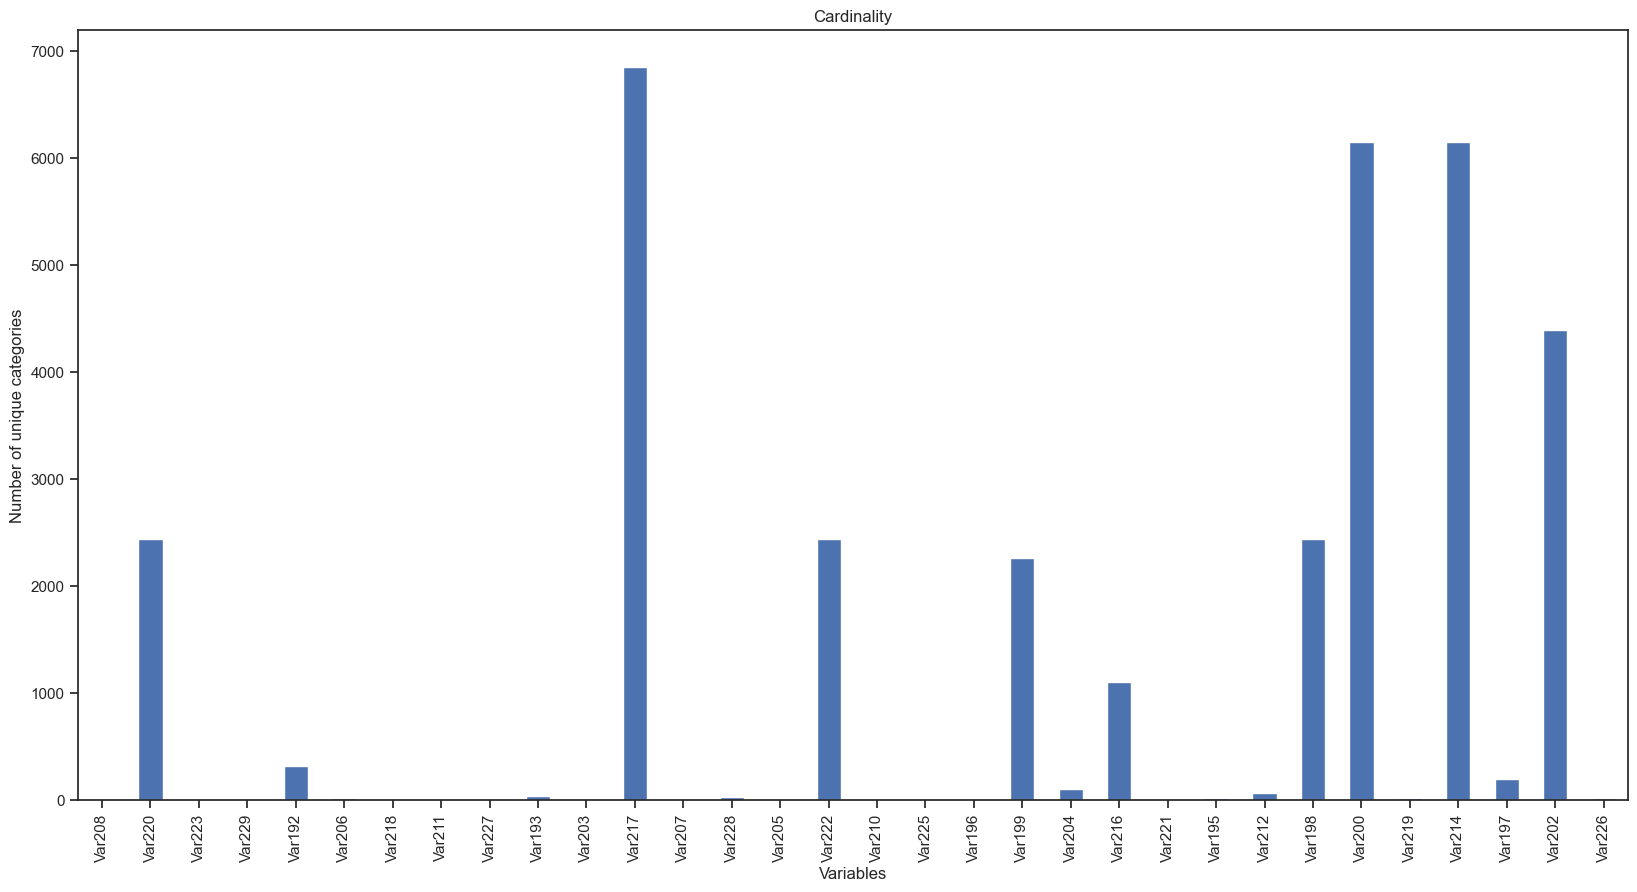

In [62]:
# The number of unique categories in a variable is called cardinality (мощность).
df[cat_features].nunique().plot.bar(figsize=(20,10))
plt.ylabel('Number of unique categories')
plt.xlabel('Variables')
plt.title('Cardinality')

Некоторые категориальные признаки могут принимать очень большое количество значений. Следовательно, в дальнейшем, при применении OneHotEncoding (в случае выбора его как кодировщика), мы буем получать очень много "мусорных" столбцов. Чтобы избежать этого, проделаем следующее преобразование:

Если категория встречается более определенного количества раз (count_criterion), будем считать ее большой, если менее - маленькой. Все категории, которые не относятся к списку из больших, заменить на категорию 'another'. В дальнейшем, при применении OneHotEncoding (преобразование категориальных переменных в dummy переменные) это позволит избежать получения огромного пространства признаков, где в колонке есть только одна единственная единичка (ну или малое количество единиц). Большое количество признаков приводит к так называемому проклятию размерности. Так же не стоит забывать что большое количество признаков приводит к переобучению.

### Обработка категориальных признаков. Стратегия 1.

Создадим функцию, которая заменяет значения признаков, которые встречаются редко (реже чем count_criterion раз) на новую категорию 'another'. Результат работы функции, измененный входной набор данных.

In [63]:
# def transform_category(df, cat_features, count_criterion = 30):
#     """
#     df - таблица "объекты - признаки".
#     cat_features - список наименований категориальных признаков.
#     count_criterion - количество различных значений, которое может принимать признак.
#     Результат работы функции - измененный df, где значения категориальных признаков встречаются редко
#     (реже чем count_criterion раз) будут заменены на новую категорию 'another'.
#     """
#     for col in cat_features:
#         category_counts = df[col].value_counts()
#         big_category = set(category_counts[category_counts >= count_criterion].index)
#         df[col] = df[col].apply(lambda w: w if w in big_category else 'another')

In [64]:
def transform_category(df, cat_features, count_criterion = 0.01):
    """
    df - таблица "объекты - признаки".
    cat_features - список наименований категориальных признаков.
    count_criterion - количество различных значений, которое может принимать признак.
    Результат работы функции - измененный df, где значения категориальных признаков встречаются редко
    (реже чем count_criterion раз) будут заменены на новую категорию 'another'.
    """
    for col in cat_features:
        category_counts = df[col].value_counts() / len(df)
        big_category = set(category_counts[category_counts >= count_criterion].index)
        df[col] = df[col].apply(lambda w: w if w in big_category else 'rare')

<span style="color:Blue;font-weight:bold">
5) Заменим значения категориальных признаков, которые встречаются редко, на новую объединенную категорию 'another'.
</span>

In [65]:
# одним из лучших результатов на отложенной выборке показал себя выбор count_criterion = 40
# transform_category(df, cat_features, count_criterion = 40)
transform_category(df, cat_features, count_criterion = 0.01)

Посмотрим как изменилась мощность категориальных признаков.

Text(0.5, 1.0, 'Cardinality')

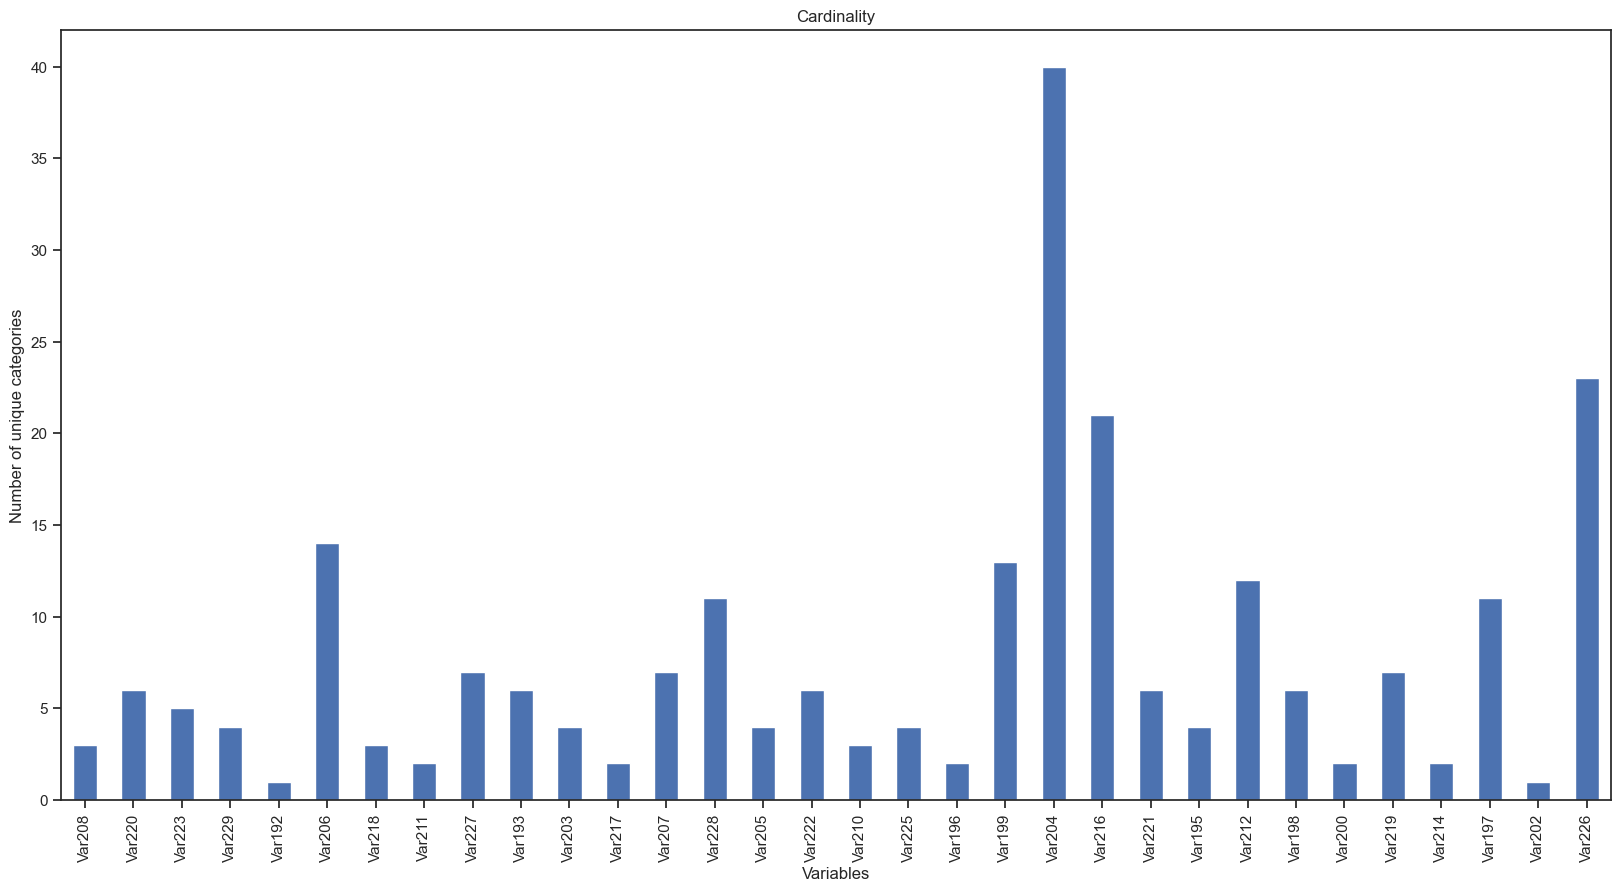

In [66]:
df[cat_features].nunique().plot.bar(figsize=(20,10))
plt.ylabel('Number of unique categories')
plt.xlabel('Variables')
plt.title('Cardinality')

Количество возможных принимаемых значений категориальных признаков уменьшилось. Но некоторые признаки все еще имеют большую мощность.

#### Создадим функцию, которая находит константные категориальные признаки (получились в результате группировки редких значений).

In [67]:
def get_single_value_features(df, cat_features):
    """
    df - dataframe
    cat_features - list of categorical features
    """
    single_value_features = []
    for col in df[cat_features].columns:
        if df[col].nunique() == 1:
            single_value_features.append(col)
    return single_value_features

<span style="color:Blue;font-weight:bold">
6) Найдем и удалим категориальные признаки с константным значением.
</span>

In [68]:
features_for_remove.keys()

dict_keys(['high_gaps', 'high_corr'])

In [69]:
features_for_remove['const_value'] = get_single_value_features(df, cat_features)

In [70]:
features_for_remove.keys()

dict_keys(['high_gaps', 'high_corr', 'const_value'])

In [71]:
features_for_remove['const_value']

['Var192', 'Var202']

In [72]:
print(f"кол-во числовых признаков = {len(num_features)}")
print(f"кол-во категориальных признаков = {len(cat_features)}")

кол-во числовых признаков = 32
кол-во категориальных признаков = 32


In [73]:
del_features(df, features_for_remove['const_value'])
print('Кол-во удаленных константных категориальных признаков составляет =',
    len(features_for_remove['const_value'])
     )
print(f"кол-во оставшихся числовых признаков = {len(num_features)}")
print(f"кол-во оставшихся категориальных признаков = {len(cat_features)}")

Кол-во удаленных константных категориальных признаков составляет = 2
кол-во оставшихся числовых признаков = 32
кол-во оставшихся категориальных признаков = 30


# Random Over Sampling

In [74]:
from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.filterwarnings('ignore')

In [75]:
X = df.copy()
y = labels.copy()
print(f"кол-во числовых признаков = {X[num_features].shape[1]}")
print(f"кол-во категориальных признаков = {X[cat_features].shape[1]}")
print(f"кол-во объектов в выборке = {X.shape[0]}")

кол-во числовых признаков = 32
кол-во категориальных признаков = 30
кол-во объектов в выборке = 14638


In [76]:
y

7817    -1.0
7734    -1.0
15976   -1.0
16978   -1.0
14906   -1.0
        ... 
7196    -1.0
6736    -1.0
12350   -1.0
12806   -1.0
17177    1.0
Name: labels, Length: 14638, dtype: float64

<Axes: xlabel='labels', ylabel='count'>

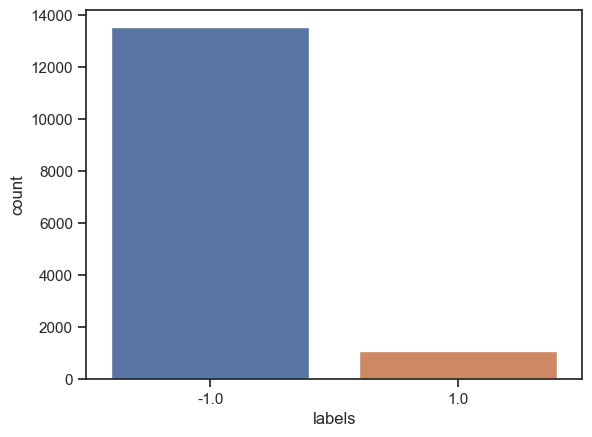

In [77]:
sns.countplot(x=y)

In [78]:
X.sample(4)

,Var6,Var7,Var13,Var24,Var28,Var35,Var38,Var44,Var57,Var65,...,Var219,Var220,Var221,Var222,Var223,Var225,Var226,Var227,Var228,Var229
6082,2737.0,7.0,396.0,18.0,166.560,0.0,108054.0,0.0,0.518479,9.0,...,FzaX,rare,d0EEeJi,rare,jySVZNlOJy,xG3x,7aLG,nIGXDli,F2FyR07IdsN7I,mj86
5381,812.0,7.0,4020.0,0.0,296.960,0.0,0.0,0.0,2.770562,18.0,...,FzaX,rare,oslk,rare,LM8l689qOp,kG3k,szEZ,RAYp,55YFVY9,mj86
10753,959.0,8.4,1836.0,4.8,197.696,0.0,60404.4,0.0,6.093997,10.8,...,FzaX,rare,oslk,rare,LM8l689qOp,missing_value,453m,RAYp,F2FyR07IdsN7I,missing_value
17394,2625.0,7.0,2272.0,2.0,33.440,0.0,162492.0,0.0,4.130527,9.0,...,FzaX,rare,d0EEeJi,rare,LM8l689qOp,ELof,xb3V,nIGXDli,F2FcTt7IdMT_v,mj86


In [79]:
column_names = list(X.columns)
ros = RandomOverSampler(sampling_strategy=1.0, random_state=1)
X, y = ros.fit_resample(X.values, y)
X = pd.DataFrame(X, columns=column_names)

<Axes: xlabel='labels', ylabel='count'>

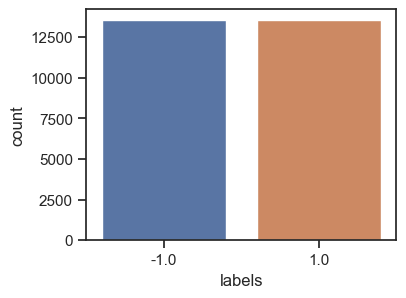

In [80]:
fig, ax = plt.subplots(figsize=(4, 3))
sns.countplot(x=y)

<span style="color:magenta;font-weight:bold">
Обработка тестовых данных (полученных на train_test_split)
</span>

<span style="color:Blue;font-weight:bold">
1) Удалим признаки, в которых количество пропусков выше заданного порога (признаки для удаления уже найдены на тренировочном наборе данных).
</span>

In [81]:
del_features(df_test, features_for_remove['high_gaps'])

print('Кол-во удаленных признаков, в которых количество пропусков выше заданного порога, составляет =',
    len(features_for_remove['high_gaps'])
     )

Кол-во удаленных признаков, в которых количество пропусков выше заданного порога, составляет = 156


<span style="color:Blue;font-weight:bold">
2) Удалим признаки, в которых корреляция между признаками выше заданного порога.
</span>

In [82]:
del_features(df_test, features_for_remove['high_corr'])
print('Кол-во уделенных числовых признаков, в которых корреляция выше заданного порога, составляет =',
    len(features_for_remove['high_corr'])
     )

Кол-во уделенных числовых признаков, в которых корреляция выше заданного порога, составляет = 10


<span style="color:Blue;font-weight:bold">
3) Заполнение пропусков в числовых признаках
</span>

In [83]:
num_imputer = KNNImputer()
# num_imputer = IterativeImputer()
# num_imputer = SimpleImputer(strategy='constant', fill_value=-999)
# num_imputer = SimpleImputer(strategy='mean')
# num_imputer = SimpleImputer(strategy='median')
df_test[num_features] = num_imputer.fit_transform(df_test[num_features])

<span style="color:Blue;font-weight:bold">
4) Заполнение пропусков в категориальных признаках
</span>

In [84]:
cat_imputer = SimpleImputer(strategy='constant', fill_value='missing_value')
df_test[cat_features] = cat_imputer.fit_transform(df_test[cat_features])

<span style="color:Blue;font-weight:bold">
5) Заменим значения категориальных признаков, которые встречаются редко, на новую объединенную категорию 'another'.
</span>

In [85]:
# transform_category(df_test, cat_features, count_criterion = 40)
transform_category(df_test, cat_features, count_criterion = 0.01)

<span style="color:Blue;font-weight:bold">
6) Удалим категориальные признаки с константным значением.
</span>

In [86]:
del_features(df_test, features_for_remove['const_value'])

print('Кол-во удаленных константных категориальных признаков составляет =',
    len(features_for_remove['const_value'])
     )

Кол-во удаленных константных категориальных признаков составляет = 2


#### Создание X_test, y_test

In [87]:
X_test = df_test.copy()
y_test = labels_test.copy()

print(f"кол-во числовых признаков = {len(num_features)}")
print(f"кол-во категориальных признаков = {len(cat_features)}")
print(f"кол-во объектов в выборке = {len(X_test)}")

кол-во числовых признаков = 32
кол-во категориальных признаков = 30
кол-во объектов в выборке = 3660


# Baseline model

In [88]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from category_encoders.count import CountEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

## Обучение модели

In [89]:
%%time
# le = LabelEncoder()
# y = le.fit_transform(y)

numeric_transformer = RobustScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = make_column_transformer(
    (numeric_transformer, num_features),
    (categorical_transformer, cat_features)
)

boost_model = GradientBoostingClassifier(random_state=1)
lgbm_model = LGBMClassifier(random_state=1)
# xgb_model = XGBClassifier(random_state=1)
# svm_model = SVC(probability=True, random_state=1)
rf_model = RandomForestClassifier(random_state=1)

boost_pipe = make_pipeline(preprocessor, boost_model)
lgbm_pipe = make_pipeline(preprocessor, lgbm_model)
# xgb_pipe = make_pipeline(preprocessor, xgb_model)
# svm_pipe = make_pipeline(preprocessor, svm_model)
rf_pipe = make_pipeline(preprocessor, rf_model)

boost_pipe.fit(X, y)
lgbm_pipe.fit(X, y)
# xgb_pipe.fit(X, y)
# svm_pipe.fit(X, y)
rf_pipe.fit(X, y)
print('Базовые модели обучены')

Базовые модели обучены
CPU times: total: 54.2 s
Wall time: 52.7 s


## Prediction

In [90]:
y_pred_boost = boost_pipe.predict_proba(X_test)
y_pred_lgbm = lgbm_pipe.predict_proba(X_test)
# y_pred_xgb = xgb_pipe.predict_proba(X_test)
# y_pred_svm = svm_pipe.predict_proba(X_test)
y_pred_rf = rf_pipe.predict_proba(X_test)

## Model Acurracy

In [91]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score

In [92]:
boost_pipe.classes_

array([-1.,  1.])

In [93]:
# pd.DataFrame(confusion_matrix(y_test, y_pred_boost), columns = ['y=1', 'y=-1'], index = ['a(x)=1', 'a(x)=-1'])

In [94]:
# pd.DataFrame(confusion_matrix(y_test, y_pred_lgbm), columns = ['y=1', 'y=-1'], index = ['a(x)=1', 'a(x)=-1'])

In [95]:
# print(classification_report(y_test, y_pred_boost))

In [96]:
# print(classification_report(y_test, y_pred_lgbm))

In [97]:
print('ROC AUC (GradientBoostingClassifier) = ', roc_auc_score(y_test, y_pred_boost[:, 1]))
print('ROC AUC (LGBMClassifier) = ', roc_auc_score(y_test, y_pred_lgbm[:, 1]))
# print('ROC AUC (XGBClassifier) = ', roc_auc_score(y_test, y_pred_xgb[:, 1]))
# print('ROC AUC (SVC) = ', roc_auc_score(y_test, y_pred_svm[:, 1]))
print('ROC AUC (RandomForestClassifier) = ', roc_auc_score(y_test, y_pred_rf[:, 1]))

# ROC AUC (GradientBoostingClassifier) =  0.7315096011816838
# ROC AUC (LGBMClassifier) =  0.6996331408620922
# ROC AUC (XGBClassifier) =  0.6615259836175641
# ROC AUC (SVC) =  0.6763679333959984
# ROC AUC (RandomForestClassifier) =  0.6936366322008862

ROC AUC (GradientBoostingClassifier) =  0.7275149724721364
ROC AUC (LGBMClassifier) =  0.6926579830804351
ROC AUC (RandomForestClassifier) =  0.6920794950986974


Посмотрим на важность признаков на основе Случайного леса.

In [98]:
%%time
X_train = X.copy()
y_train = y.copy()

X_train[num_features] = RobustScaler().fit_transform(X_train[num_features])
X_train[cat_features] = CountEncoder().fit_transform(X_train[cat_features])

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

CPU times: total: 7.19 s
Wall time: 7.22 s


RandomForestClassifier()

### Визуализируем важность признаков

Для представления значений важности признаков будем использовать гистограмму. Сначала создадим промежуточную таблицу данных с именами признаков и их соответствующими значениями важностями.

In [99]:
importances_df = pd.DataFrame({"feature_names" : rf.feature_names_in_, 
                               "importances" : rf.feature_importances_})
importances_df.sort_values(by='importances', inplace=True, ascending=False)
importances_df.head(4)

,feature_names,importances
19,Var126,0.067810
31,Var189,0.045936
17,Var113,0.043395
8,Var57,0.039101


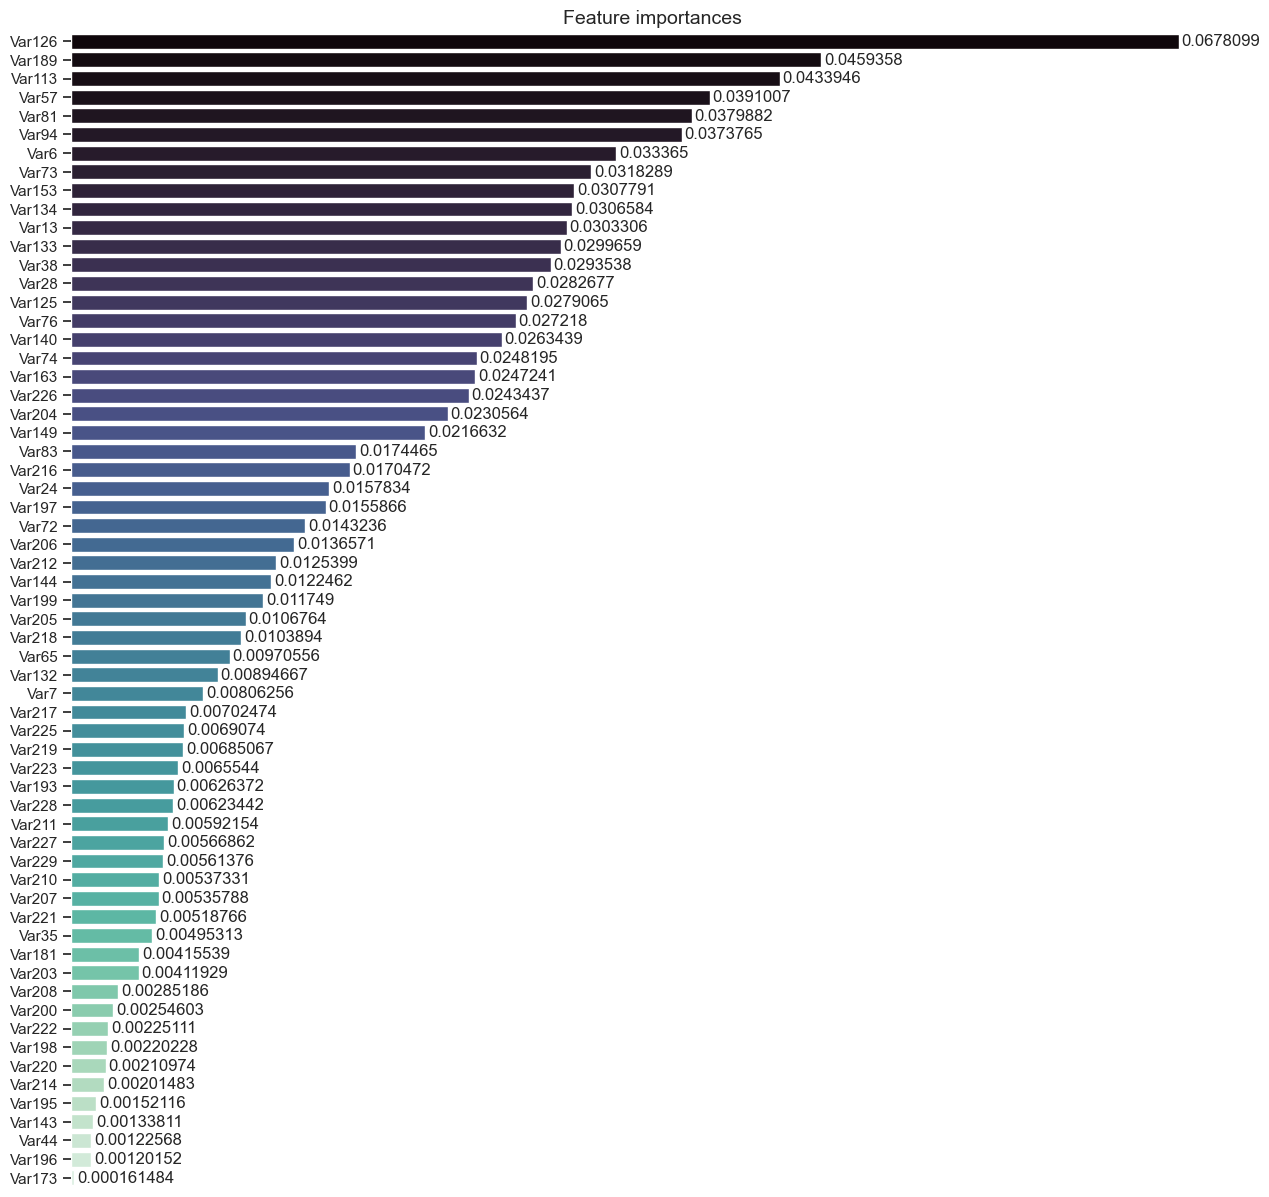

In [100]:
fig, ax = plt.subplots(figsize=(15, 15))
g = sns.barplot(data=importances_df, 
                x="importances", 
                y="feature_names",
                
                # adding mako palette
                palette="mako")
sns.despine(bottom=True, left=True)
g.set_title("Feature importances", fontsize=14)
g.set(xticks=[])
g.set(xlabel=None)
g.set(ylabel=None)
for value in g.containers:
    g.bar_label(value, 
                padding=2) # adding space (padding) between bars and values

In [101]:
features_for_remove.keys()

dict_keys(['high_gaps', 'high_corr', 'const_value'])

Посмотрим более внимательно на признаки, которые алгоритм случайного леса определил как наименее важные.

In [102]:
features_for_remove['low_importance'] = list(importances_df['feature_names'][-11:])

In [103]:
print(f"кол-во числовых признаков = {len(num_features)}")
print(f"кол-во категориальных признаков = {len(cat_features)}")

кол-во числовых признаков = 32
кол-во категориальных признаков = 30


In [104]:
features_for_remove['low_importance']

['Var208',
 'Var200',
 'Var222',
 'Var198',
 'Var220',
 'Var214',
 'Var195',
 'Var143',
 'Var44',
 'Var196',
 'Var173']

<span style="color:Blue;font-weight:bold">
6) Удалим наименее важные признаки (11 наименее важных)
</span>

In [105]:
del_features(X, features_for_remove['low_importance'])

print('Кол-во удаленных признаков, которые признаны как наименее важными =',
    len(features_for_remove['low_importance'])
     )
print(f"кол-во оставшихся числовых признаков = {len(num_features)}")
print(f"кол-во оставшихся категориальных признаков = {len(cat_features)}")

Кол-во удаленных признаков, которые признаны как наименее важными = 11
кол-во оставшихся числовых признаков = 29
кол-во оставшихся категориальных признаков = 22


In [106]:
del_features(X_test, features_for_remove['low_importance'])

### Попробуем повторно обучить базовые модели на оставшихся признаках.

In [107]:
%%time
# le = LabelEncoder()
# y = le.fit_transform(y)

numeric_transformer = RobustScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = make_column_transformer(
    (numeric_transformer, num_features),
    (categorical_transformer, cat_features)
)

boost_model = GradientBoostingClassifier(random_state=1)
lgbm_model = LGBMClassifier(random_state=1)
# xgb_model = XGBClassifier(random_state=1)
# svm_model = SVC(probability=True, random_state=1)
rf_model = RandomForestClassifier(random_state=1)

boost_pipe = make_pipeline(preprocessor, boost_model)
lgbm_pipe = make_pipeline(preprocessor, lgbm_model)
# xgb_pipe = make_pipeline(preprocessor, xgb_model)
# svm_pipe = make_pipeline(preprocessor, svm_model)
rf_pipe = make_pipeline(preprocessor, rf_model)

boost_pipe.fit(X, y)
lgbm_pipe.fit(X, y)
# xgb_pipe.fit(X, y)
# svm_pipe.fit(X, y)
rf_pipe.fit(X, y)
print('Базовые модели обучены')

Базовые модели обучены
CPU times: total: 50.7 s
Wall time: 49.1 s


In [108]:
y_pred_boost = boost_pipe.predict_proba(X_test)
y_pred_lgbm = lgbm_pipe.predict_proba(X_test)
# y_pred_xgb = xgb_pipe.predict_proba(X_test)
# y_pred_svm = svm_pipe.predict_proba(X_test)
y_pred_rf = rf_pipe.predict_proba(X_test)

In [109]:
print('ROC AUC (GradientBoostingClassifier) = ', roc_auc_score(y_test, y_pred_boost[:, 1]))
print('ROC AUC (LGBMClassifier) = ', roc_auc_score(y_test, y_pred_lgbm[:, 1]))
# print('ROC AUC (XGBClassifier) = ', roc_auc_score(y_test, y_pred_xgb[:, 1]))
# print('ROC AUC (SVC) = ', roc_auc_score(y_test, y_pred_svm[:, 1]))
print('ROC AUC (RandomForestClassifier) = ', roc_auc_score(y_test, y_pred_rf[:, 1]))

# ROC AUC (GradientBoostingClassifier) =  0.7315096011816838
# ROC AUC (LGBMClassifier) =  0.6996331408620922
# ROC AUC (XGBClassifier) =  0.6615259836175641
# ROC AUC (SVC) =  0.6763679333959984
# ROC AUC (RandomForestClassifier) =  0.6936366322008862

ROC AUC (GradientBoostingClassifier) =  0.7310337048475898
ROC AUC (LGBMClassifier) =  0.7111223311400564
ROC AUC (RandomForestClassifier) =  0.6916873908956628


Отбор признаков на основе Решающего дерева не принес пользы. Некоторые модели потеряли немного в точности.

## Hyperparameter tuning for GradientBoostingClassifier

In [110]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [111]:
%%time

# numeric_transformer = StandardScaler()
numeric_transformer = RobustScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
# categorical_transformer = CountEncoder()
# categorical_transformer = LabelEncoder()

preprocessor = make_column_transformer(
    (numeric_transformer, num_features),
    (categorical_transformer, cat_features)
)

learning_rates = [0.2, 0.15, 0.1]
number_of_estimators = [22, 23, 24, 25, 60, 70, 80, 100, 120, 150]
maximum_depth = [4, 3, 2]
# loss_functions = ['deviance', 'exponential']

best_estimator = {
    'learning_rate': None,
    'n_estimators': None,
    'max_depth': None,
    'roc_auc_score': 0
}

for max_depth in maximum_depth:
    for learning_rate in learning_rates:
        for n_estimators in number_of_estimators:
            boost_model = GradientBoostingClassifier(
                learning_rate=learning_rate,
                n_estimators=n_estimators,
                max_depth=max_depth,
                random_state=42)
            boost_pipe = make_pipeline(preprocessor, boost_model)
            boost_pipe.fit(X, y)
            y_pred = boost_pipe.predict_proba(X_test)
            y_pred = y_pred[:, 1]
            
            score = roc_auc_score(y_test, y_pred)
            if score > best_estimator['roc_auc_score']:
                best_estimator['learning_rate'] = learning_rate
                best_estimator['n_estimators'] = n_estimators
                best_estimator['max_depth'] = max_depth
                best_estimator['roc_auc_score'] = score

CPU times: total: 19min 20s
Wall time: 19min 24s


In [112]:
best_estimator

# {'learning_rate': 0.1,
#  'n_estimators': 70,
#  'max_depth': 2,
#  'roc_auc_score': 0.7359210420303478}

{'learning_rate': 0.1,
 'n_estimators': 80,
 'max_depth': 3,
 'roc_auc_score': 0.7333095206123271}

## Hyperparameter tuning for LGBMClassifier

In [113]:
%%time

# numeric_transformer = StandardScaler()
numeric_transformer = RobustScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
# categorical_transformer = CountEncoder()
# categorical_transformer = LabelEncoder()

preprocessor = make_column_transformer(
    (numeric_transformer, num_features),
    (categorical_transformer, cat_features)
)

learning_rates = [0.05, 0.1, 0.04, 0.07, 0.03, 0.02]
number_of_estimators = [180, 190, 200, 24, 150, 70, 100, 50, 220, 210, 240]
maximum_depth = [4, 3, 2, -1]
number_of_leaves = [32, 31, 33, 30]

best_estimator = {
    'learning_rate': None,
    'n_estimators': None,
    'max_depth': None,
    'num_leaves': None,
    'roc_auc_score': 0
}

for num_leaves in number_of_leaves:
    for max_depth in maximum_depth:
        for learning_rate in learning_rates:
            for n_estimators in number_of_estimators:
                lgbm_model = LGBMClassifier(
                    learning_rate=learning_rate,
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    num_leaves=num_leaves,
                    random_state=42)
                lgbm_pipe = make_pipeline(preprocessor, lgbm_model)
                lgbm_pipe.fit(X, y)
                y_pred = lgbm_pipe.predict_proba(X_test)
                y_pred = y_pred[:, 1]
            
                score = roc_auc_score(y_test, y_pred)
                if score > best_estimator['roc_auc_score']:
                    best_estimator['learning_rate'] = learning_rate
                    best_estimator['n_estimators'] = n_estimators
                    best_estimator['max_depth'] = max_depth
                    best_estimator['num_leaves'] = num_leaves
                    best_estimator['roc_auc_score'] = score

CPU times: total: 38min 9s
Wall time: 10min 16s


In [114]:
best_estimator

# {'learning_rate': 0.04,
#  'n_estimators': 200,
#  'max_depth': 2,
#  'num_leaves': 32,
#  'roc_auc_score': 0.7389928830401504}

{'learning_rate': 0.03,
 'n_estimators': 240,
 'max_depth': 2,
 'num_leaves': 32,
 'roc_auc_score': 0.7356331408620921}

# Fit on the best model

In [110]:
%%time

numeric_transformer = RobustScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = make_column_transformer(
    (numeric_transformer, num_features),
    (categorical_transformer, cat_features)
)

best_model = GradientBoostingClassifier(learning_rate=0.2, n_estimators=60, max_depth=2, random_state=1)
pipe = make_pipeline(preprocessor, best_model)
pipe.fit(X, y)
print('Лучшая модель обучена')

Лучшая модель обучена
CPU times: total: 7.05 s
Wall time: 7.08 s


In [111]:
%%time

numeric_transformer = RobustScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = make_column_transformer(
    (numeric_transformer, num_features),
    (categorical_transformer, cat_features)
)

best_model_lgbm = LGBMClassifier(
    learning_rate=0.05,
    n_estimators=210,
    max_depth=2,
    num_leaves=32,
    random_state=1)

pipe_lgbm = make_pipeline(preprocessor, best_model_lgbm)
pipe_lgbm.fit(X, y)
print('Лучшая модель LGBMClassifier обучена')

Лучшая модель LGBMClassifier обучена
CPU times: total: 1.19 s
Wall time: 403 ms


# Prediction with best model

In [112]:
y_pred_best_model = pipe.predict_proba(X_test)
print('ROC AUC (GradientBoostingClassifier) = ', roc_auc_score(y_test, y_pred_best_model[:, 1]))

y_pred_best_model_lgbm = pipe_lgbm.predict_proba(X_test)
print('ROC AUC (LGBMClassifier) = ', roc_auc_score(y_test, y_pred_best_model_lgbm[:, 1]))

ROC AUC (GradientBoostingClassifier) =  0.7349536726198469
ROC AUC (LGBMClassifier) =  0.7390637840741239


# Загрузка контрольных данных (kaggle)

In [113]:
X_control = pd.read_csv('orange_small_churn_test_data.csv')
X_control.drop('ID', axis=1, inplace=True)

# 1) удаление признаков с высокой долей пропусков
del_features(X_control, features_for_remove['high_gaps'])

# 2) удаление числовых признаков с высокой корреляцией
del_features(X_control, features_for_remove['high_corr'])

# 3) заполнение пропусков в числовых признаках средним (нулем)
num_imputer = KNNImputer()
# num_imputer = IterativeImputer()
# num_imputer = SimpleImputer(strategy='constant', fill_value=-999)
# num_imputer = SimpleImputer(strategy='mean')
# num_imputer = SimpleImputer(strategy='median')
X_control[num_features] = num_imputer.fit_transform(X_control[num_features])

# 4) заполнение пропусков в категориальных признаках константой
cat_imputer = SimpleImputer(strategy='constant', fill_value='missing_data')
X_control[cat_features] = cat_imputer.fit_transform(X_control[cat_features])

# 5) преобразование категориальных признаков
transform_category(X_control, cat_features, count_criterion = 0.01)

# 6) удаление наименее важных признаков (feature_importance_)
del_features(X_control, features_for_remove['low_importance'])

## Предсказание на контрольных данных

In [114]:
# y_pred = pipe.predict_proba(X_control)
# y_pred = y_pred[:, 1]

y_pred = pipe_lgbm.predict_proba(X_control)
y_pred = y_pred[:, 1]

## Создание ответа для Kaggle

In [115]:
data_test = pd.read_csv('orange_small_churn_test_data.csv') # нужно только для считывания ID
output = pd.DataFrame({'ID': data_test['ID'], 'result': y_pred})
output.to_csv('my_submission_4.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [116]:
X_control.columns

Index(['Var6', 'Var7', 'Var13', 'Var24', 'Var28', 'Var35', 'Var38', 'Var57',
       'Var65', 'Var72', 'Var73', 'Var74', 'Var76', 'Var81', 'Var94', 'Var109',
       'Var113', 'Var125', 'Var126', 'Var132', 'Var133', 'Var134', 'Var140',
       'Var144', 'Var149', 'Var153', 'Var163', 'Var189', 'Var192', 'Var193',
       'Var197', 'Var199', 'Var202', 'Var203', 'Var204', 'Var205', 'Var206',
       'Var207', 'Var208', 'Var210', 'Var211', 'Var212', 'Var216', 'Var217',
       'Var218', 'Var219', 'Var221', 'Var223', 'Var225', 'Var226', 'Var227',
       'Var228', 'Var229'],
      dtype='object')

In [123]:
'Var44' in X_control.columns

False

In [125]:
X['Var217'].value_counts()

rare             26136
missing_value      936
Name: Var217, dtype: int64